In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
import json
import pprint
import scipy.stats as stats
import urllib
from urllib.parse import quote
import re

# # Used for census.gov data
# from census import Census

# Census API Key
from config import census_key
from config import yelp_key

# c = Census(census_key, year=2013)

In [2]:
#File with ZIP Code data
file = 'input/zipcodes_sea.csv'

# Read all ZIP codes with their Latitude and Longitude for the St. Louis City and St. Louis County area
# When testing use a small set of ZIP Codes: df_zip = df.iloc[0:5,:]
df_zip = pd.read_csv(file)

zip_count = df_zip.zip_code.count()
print(f"Total zip codes: {zip_count}")
df_zip.head()

Total zip codes: 35


,zip_code,county,latitude,longetude
0,98164,King,47.606139,-122.33186
1,98134,King,47.578670,-122.33441
2,98148,King,47.443756,-122.33068
3,98101,King,47.610670,-122.33438
4,98121,King,47.614870,-122.34578


In [3]:
# Get ready to import yelp data
API_KEY=yelp_key

API_HOST = 'https://api.yelp.com'
SEARCH_PATH = '/v3/businesses/search'
MATCH_PATH = '/v3/businesses/matches'
SEARCH_PHONE_PATH = '/v3/businesses/search/phone'
BUSINESS_PATH = '/v3/businesses/'  # Business ID will come after slash

In [4]:
def request(host, path, api_key, url_params=None):
    url_params = url_params or {}
    url = '{0}{1}'.format(host, quote(path.encode('utf8')))
    headers = {
        'Authorization': 'Bearer %s' % api_key,
    }
#     print(u'Querying {0} ...'.format(url))
#     print(headers)

    response = requests.request('GET', url, headers=headers, params=url_params)
    return response.json() #, my_url

In [5]:
df_businesses = pd.DataFrame()
df_bus_total = pd.DataFrame()
prices = []
dict_total = {}

for index, row in df_zip.iterrows():
    row_zip = row[0]
    row_city = row[1]
    row_lat = row[2]
    row_long = row[3]
    #     print(index, row_zip, row_lat, row_long)
    url_params={"city":row_city, 'zip_code':row_zip,'latitude':row_lat,'longitude':row_long}
    dict_businesses = request(API_HOST, SEARCH_PATH, API_KEY, url_params)

    df_businesses['business_id']=[business["id"] for business in dict_businesses['businesses']]
    df_businesses['name']=[business["name"]for business in dict_businesses['businesses']]
    df_businesses['rating']=[business["rating"]for business in dict_businesses['businesses']]
    df_businesses['zip_code']=[business['location']["zip_code"]for business in dict_businesses['businesses']]
    df_businesses['review_count']=[business["review_count"]for business in dict_businesses['businesses']]

    for b in dict_businesses['businesses']:
        try:
            my_price = b['price']
            prices.append(my_price)
        except:
            prices.append('*')
    
#     dict_total.update(dict_businesses)
    
    df_bus_total = df_bus_total.append(df_businesses)

df_bus_total.head()

,business_id,name,rating,zip_code,review_count
0,6I28wDuMBR5WLMqfKxaoeg,Pike Place Chowder,4.5,98101,7142
1,NxwrJPJLzTs0k0DQ-QCo1A,Piroshky Piroshky,4.5,98101,6014
2,CKxp6p22ipCo94iLieXzbQ,Ellenos Real Greek Yogurt,5.0,98101,1769
3,VOPdG8llLPaga9iJxXcMuQ,The Pink Door,4.5,98101,4946
4,L8RRAd-JZ0Bd4MER0yyX-g,Japonessa Sushi Cocina,4.0,98101,4545


In [6]:
# Add prices info and cleanup
df_bus_total['price'] = prices
df_bus_total = df_bus_total.loc[(df_bus_total['price'] != '*')]
bus_count = df_bus_total.business_id.count()
print(f"Total businesses: {bus_count}")
# df_bus_total.head()

df_bus_total.head()

Total businesses: 671


,business_id,name,rating,zip_code,review_count,price
0,6I28wDuMBR5WLMqfKxaoeg,Pike Place Chowder,4.5,98101,7142,$$
1,NxwrJPJLzTs0k0DQ-QCo1A,Piroshky Piroshky,4.5,98101,6014,$
2,CKxp6p22ipCo94iLieXzbQ,Ellenos Real Greek Yogurt,5.0,98101,1769,$
3,VOPdG8llLPaga9iJxXcMuQ,The Pink Door,4.5,98101,4946,$$
4,L8RRAd-JZ0Bd4MER0yyX-g,Japonessa Sushi Cocina,4.0,98101,4545,$$


In [7]:
# Specify the file to write to
output_path = os.path.join("output", "business_data_sea.csv")
df_bus_total.to_csv(output_path)

In [8]:
# Drop duplicates
df_bus_total = df_bus_total.sort_values('business_id')
df_bus_total = df_bus_total.reset_index(drop=True)
df_bus_unique = df_bus_total.drop_duplicates(['business_id'], keep='first')

In [9]:
bus_uni_count = df_bus_unique.business_id.count()
print(f"Total unique businesses: {bus_uni_count}")
df_bus_unique.head()
# Optionally use a smaller data set: df_bus_unique_small = df_bus_unique[1:5]

Total unique businesses: 378


,business_id,name,rating,zip_code,review_count,price
0,-FOAQv22SXtSBs7nptI3UA,Serious Pie,4.0,98121,4081,$$
6,-YlkKYlHYKNcrBs21V-WfQ,Chinook's,4.0,98119,829,$$
7,-ofDNmj8r_F875FiZr9G8w,Witness,4.5,98102,769,$$
9,-pa-22jT0ssGBiBaGQWiqA,The Harvest Vine,4.5,98112,606,$$$
11,-qeVTbSB0Gv59dUiNUTVNA,Le's Pho Tai,4.0,98133,255,$$


In [10]:
# Specify the file to write to
output_path = os.path.join("output", "business_unique_data_sea.csv")
df_bus_unique.to_csv(output_path)

In [11]:
# Get reviews for each unique business
dict_rev_total = {}
dict_reviews = {}
df_reviews = pd.DataFrame()
df_rev_total = pd.DataFrame()

for index, row in df_bus_unique.iterrows():
    row_bus = row[0]
#     print(row_bus)
    REVIEW_PATH = BUSINESS_PATH + row_bus + '/reviews'
    dict_reviews = request(API_HOST, REVIEW_PATH, API_KEY)
#     pprint.pprint(dict_reviews)
    try:
        df_reviews['business_id']= [row_bus for review in dict_reviews['reviews']]
        df_reviews['review_id']=[review["id"]for review in dict_reviews['reviews']]
        df_reviews['rating']=[review["rating"]for review in dict_reviews['reviews']]
        df_reviews['name']=[review['user']["name"]for review in dict_reviews['reviews']]
        df_rev_total = df_rev_total.append(df_reviews)
    except:
        pass

In [12]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 1134


,business_id,review_id,rating,name
0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.
1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.
2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.
0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.
1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.


In [13]:
#COMMENT OUT THE RESET BELOW IF RAN MULTIPLE TIMES!!!!

df_rev_total.reset_index(inplace=True)

# create a list with names per review and take only the name before the 'space' as a first name
df_rev_total['short name']=""
short_name = []
for index, row in df_rev_total.iterrows():
#     print(row)
    short_name = re.split("( )",row[4])
#     print(short_name)
    df_rev_total.iloc[index, 5] = short_name[0].lower()

In [14]:
rev_uni_count = df_rev_total.review_id.count()
print(f"Total reviews: {rev_uni_count}")
df_rev_total.head()

Total reviews: 1134


,index,business_id,review_id,rating,name,short name
0,0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.,johanna
1,1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian
2,2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.,sharon
3,0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.,artemis
4,1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.,michael


In [15]:
file = 'input/gender names.csv'
df = pd.read_csv(file)
df = df.set_index('first_name')
df.head()

,nameprimary,gender,count
first_name,,,
aa,AA,Not Known,1
aabha,AABHA,Female,1
aabida,AABIDA,Female,1
aad,AAD,Male,1
aadarsh,AADARSH,Male,1


In [16]:
df_rev_total['gender']=""
gender = []
for index, row in df_rev_total.iterrows():
    try:
        gender = df.loc[str(row[5]),'gender']
    #     print(gender)
        df_rev_total.iloc[index, 6] = gender
    except:
        pass
df_rev_total.head()

# Drop reviews with where gender isn't found
df_rev_total = df_rev_total.loc[(df_rev_total['gender']!="") & (df_rev_total['gender']!="Both") & (df_rev_total['gender']!="Not Known")]

In [17]:
# Specify the file to write to
df_rev_total = df_rev_total.rename(columns={'rating':'reviewer_rating', 'name':'reviewer_full'})
output_path = os.path.join("output", "review_by_gender_data_sea.csv")
df_rev_total.to_csv(output_path)

rev_gender_count = df_rev_total.review_id.count()
print(f"Total reviews with gender: {rev_gender_count}")

# Specify the file to write to
output_path = os.path.join("output", "review_data_sea.csv")
df_rev_total.to_csv(output_path)

df_rev_total.head()

Total reviews with gender: 938


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender
0,0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.,johanna,Female
1,1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian,Male
2,2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.,sharon,Female
3,0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.,artemis,Female
4,1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.,michael,Male


In [18]:
df_total = pd.merge(df_rev_total, df_bus_total,on=('business_id'))
# Somehow renaming columns duplicated rows
df_total = df_total.drop_duplicates()
# df_total.count()

In [19]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_sea.csv")
df_total.to_csv(output_path)

total_count = df_total.review_id.count()
print(f"Total reviews: {total_count}")
df_total.head()

Total reviews: 938


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price
0,0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.,johanna,Female,Serious Pie,4.0,98121,4081,$$
6,1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian,Male,Serious Pie,4.0,98121,4081,$$
12,2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.,sharon,Female,Serious Pie,4.0,98121,4081,$$
18,0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.,artemis,Female,Chinook's,4.0,98119,829,$$
19,1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.,michael,Male,Chinook's,4.0,98119,829,$$


In [20]:
df_total['price_num'] = df_total['price']
df_total['price_num'] = df_total['price_num'].replace(
    {'$':1,'$$':2,'$$$':3,'$$$$':4})

df_total

,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price,price_num
0,0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.,johanna,Female,Serious Pie,4.0,98121,4081,$$,2
6,1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian,Male,Serious Pie,4.0,98121,4081,$$,2
12,2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.,sharon,Female,Serious Pie,4.0,98121,4081,$$,2
18,0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.,artemis,Female,Chinook's,4.0,98119,829,$$,2
19,1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.,michael,Male,Chinook's,4.0,98119,829,$$,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,0,zV3tTEWnDrWWT07baEyi-Q,mVkyVI_XesslhVOyDg_caw,5,Arnab D.,arnab,Male,Queen Bee Cafe,4.5,98112,386,$,1
1671,1,zV3tTEWnDrWWT07baEyi-Q,uRbTgoJQw84988lH3hdGRA,4,Katherine Y.,katherine,Female,Queen Bee Cafe,4.5,98112,386,$,1
1673,2,zV3tTEWnDrWWT07baEyi-Q,8r2Xdh8-lrJUWeG67ZFl0w,4,Victoria M.,victoria,Female,Queen Bee Cafe,4.5,98112,386,$,1
1675,1,znC7nKUjIpMxTRrJjtnazQ,i4oRy5aTv7nheDpiLf-n4A,4,Mitchell V.,mitchell,Male,Toyoda Sushi,4.0,98125,330,$$,2


In [ ]:
# df_zip = df_zip.rename(columns={'ZIP Code':'zip_code'})
# df_total['zip_code'] = pd.to_numeric(df_total['zip_code'])
# df_total_zip = pd.merge(df_total, df_zip, on='zip_code', how='outer')
# df_total_zip.head()

In [21]:
# Specify the file to write to
output_path = os.path.join("output", "total_everything_sea.csv")
df_total.to_csv(output_path)

Female    579
Male      359
Name: gender, dtype: int64


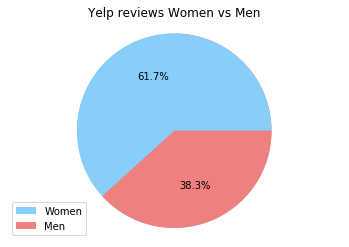

In [22]:
total_reviews = df_total['gender'].value_counts()

plt.clf()
colors = ['lightskyblue', 'lightcoral']
labels = ['Women','Men']
patches, texts = plt.pie(total_reviews, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(total_reviews, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Yelp reviews Women vs Men")
plt.savefig("Images/Women_vw_Men_sea.png")

print(total_reviews)


,index,business_id,review_id,reviewer_rating,reviewer_full,short name,gender,name,rating,zip_code,review_count,price,price_num,count_1
0,0,-FOAQv22SXtSBs7nptI3UA,rMNUJ0f-V1oN6O4Jz2qP9Q,5,Johanna M.,johanna,Female,Serious Pie,4.0,98121,4081,$$,2,1
6,1,-FOAQv22SXtSBs7nptI3UA,IthS8Rb-GYIZ9OhgWuJeWQ,3,Julian S.,julian,Male,Serious Pie,4.0,98121,4081,$$,2,1
12,2,-FOAQv22SXtSBs7nptI3UA,35-4Cw_-vm7HwoQANbzfWg,4,Sharon T.,sharon,Female,Serious Pie,4.0,98121,4081,$$,2,1
18,0,-YlkKYlHYKNcrBs21V-WfQ,cetLa1hxD2Q2jhsbGGKn1g,5,Artemis L.,artemis,Female,Chinook's,4.0,98119,829,$$,2,1
19,1,-YlkKYlHYKNcrBs21V-WfQ,9FNNxuN0Y5eGTWVQLUOUvA,4,Michael G.,michael,Male,Chinook's,4.0,98119,829,$$,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1669,0,zV3tTEWnDrWWT07baEyi-Q,mVkyVI_XesslhVOyDg_caw,5,Arnab D.,arnab,Male,Queen Bee Cafe,4.5,98112,386,$,1,1
1671,1,zV3tTEWnDrWWT07baEyi-Q,uRbTgoJQw84988lH3hdGRA,4,Katherine Y.,katherine,Female,Queen Bee Cafe,4.5,98112,386,$,1,1
1673,2,zV3tTEWnDrWWT07baEyi-Q,8r2Xdh8-lrJUWeG67ZFl0w,4,Victoria M.,victoria,Female,Queen Bee Cafe,4.5,98112,386,$,1,1
1675,1,znC7nKUjIpMxTRrJjtnazQ,i4oRy5aTv7nheDpiLf-n4A,4,Mitchell V.,mitchell,Male,Toyoda Sushi,4.0,98125,330,$$,2,1


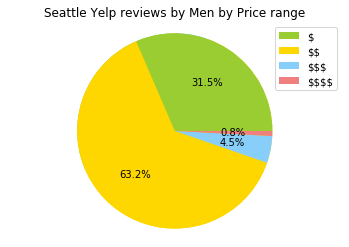

In [51]:
# use line below to bypass API calls
# df_total = pd.read_csv('output/total_everything_sea.csv')

men_sizes = []
df_only_men = df_total.loc[(df_total["gender"] == 'Male')]

df_only_men_price_count = df_only_men.loc[(df_only_men["price"] != '*')]
# df_only_men_price_count = df_only_men.loc[(df_only_men["reviewer_rating"] != '*')]

df_only_men_price_count_gb = df_only_men_price_count.groupby(['price'])
# df_only_men_price_count_gb = df_only_men_price_count.groupby(['reviewer_rating'])

men_sizes = df_only_men_price_count_gb['price'].count()
# men_sizes = df_only_men_price_count_gb['reviewer_rating'].count()

# avg_rating_men = df_only_men_price_count['reviewer_rating'].mean()
# print(avg_rating_men)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']

patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(men_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Seattle Yelp reviews by Men by Price range")
plt.savefig("Images/Men_Price_Reviews_sea.png")
# df_only_men_price_count['reviewer_rating'].value_counts()
men_sizes
df_total

4.238341968911917


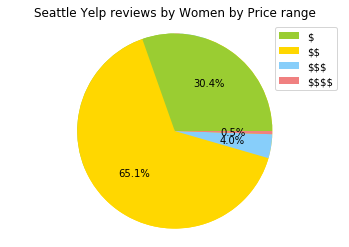

price
$       176
$$      377
$$$      23
$$$$      3
Name: price, dtype: int64

In [49]:
women_sizes = []
df_only_women = df_total.loc[(df_total["gender"] == 'Female')]

df_only_women_price_count = df_only_women.loc[(df_only_women["price"] != '*')]
# df_only_women_price_count = df_only_women.loc[(df_only_women["reviewer_rating"] != '*')]

df_only_women_price_count_gb = df_only_women_price_count.groupby(['price'])
# df_only_women_price_count_gb = df_only_women_price_count.groupby(['reviewer_rating'])

women_sizes = df_only_women_price_count_gb['price'].count()
# women_sizes = df_only_women_price_count_gb['reviewer_rating'].count()

avg_rating_women = df_only_women_price_count['rating'].mean()
print(avg_rating_women)

plt.clf()
colors = ['yellowgreen', 'gold', 'lightskyblue', 'lightcoral']
labels = ['\$','\$\$','\$\$\$','\$\$\$\$']
patches, texts = plt.pie(men_sizes, colors=colors, startangle=90)
plt.legend(patches, labels, loc="best")
plt.pie(women_sizes, colors=colors, autopct="%1.1f%%")
plt.axis('equal')
# plt.tight_layout()
plt.title("Seattle Yelp reviews by Women by Price range")
plt.savefig("Images/Women_Price_Reviews_sea.png")
plt.show()
women_sizes

In [ ]:
# # bins = [0,3,3.5,4,4.5,5]
# bins = [0,1,2,3,4,5]
# # group_names = ['0-3', '3.0-3.5','3.5-4','4.0-4.5','4.5-5']
# group_names = ['*','**','***','****','*****']

# s1 = pd.Series(group_names)
# df_summary = pd.DataFrame(list(s1), columns=["Rating"])
# df_summary = df_summary.set_index(['Rating'])

# df_total['Rating'] = pd.cut(df_total['reviewer_rating'], bins, labels=group_names)
# df_total_women = df_total.loc[df_total['gender']=='Female',['reviewer_rating','Rating']]
# df_total_women = df_total_women.iloc[0:338,:]
# df_total_men = df_total.loc[df_total['gender']=='Male',['reviewer_rating','Rating']]
# df_total_men = df_total_men.iloc[0:338,:]
# df_total_other = df_total.loc[(df_total['gender']!='Female') & (df_total['gender']!='Male'),['reviewer_rating','Rating']]

# df_total_other_gb = df_total_other.groupby(['Rating'])
# df_total_women_gb = df_total_women.groupby(['Rating'])
# df_total_men_gb = df_total_men.groupby(['Rating'])
# df_total_gb = df_total.groupby(['Rating'])
# # df_total_other_gb = df_total_other.groupby(['Bracket'])

# rating_women = df_total_women_gb.count()
# rating_men = df_total_men_gb.count()
# rating_other = df_total_other_gb.count()
# rating_total = df_total_gb['rating'].count()


# # rating_other = df_total_women_gb.count()
# df_summary['men'] = rating_men
# df_summary['women'] = rating_women
# df_summary['other'] = rating_other
# df_summary['total'] = rating_total

# print(df_summary)
# plt.clf()
# x_axis = group_names
# x_axis
# tick_locations = np.arange(0, 5, 1)
# tick_locations
# ax = df_summary[['men','women']].plot(kind='bar', title ="Men vs Women Ratings", legend=True,rot=0, fontsize=12)
# ax.xlabel = 'Rating by Bracket'

# plt.savefig("Images/Men_vs_Women_Rating.png")

# print(df_summary)

gender           Female  Male
reviewer_rating              
1                    16    25
2                    25    19
3                    41    29
4                   103   105
5                   174   181


<Figure size 432x288 with 0 Axes>

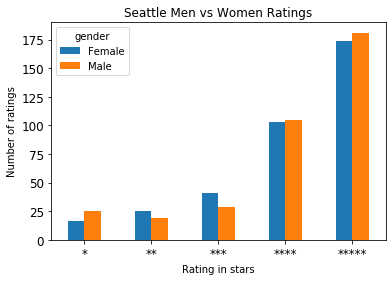

In [50]:
df_total_male = df_total.loc[df_total['gender']=='Male']
df_total_female = df_total.loc[df_total['gender']=='Female']

max_men = df_total_male['reviewer_rating'].count()
df_total_female = df_total_female.iloc[0:max_men,:]

df_total_m_f = df_total_male
df_total_m_f = df_total_m_f.append(df_total_female)

df_summary_reviews_gb = df_total_m_f.groupby(['reviewer_rating','gender'])
df_summary_reviews = pd.DataFrame(df_summary_reviews_gb['review_id'].count())
df_summary_pivot = df_summary_reviews.pivot_table('review_id','reviewer_rating','gender')
df_summary_pivot

plt.clf()

x_axis = ['*','**','***','****','*****']
# x_axis
tick_locations = np.arange(0, 5, 1)
# tick_locations
ax = df_summary_pivot[['Female','Male']].plot(kind='bar', title ="Seattle Men vs Women Ratings", legend=True,rot=0, fontsize=12)
# ax.xlabel = 'Rating by Bracket'
plt.xticks(tick_locations, x_axis)
plt.xlabel("Rating in stars")
plt.ylabel("Number of ratings")
plt.savefig("Images/Men_vs_Women_Rating_sea.png")

print(df_summary_pivot)

In [26]:
# df_total.head()
df_zipcodes = df_total.groupby(['zip_code','gender'])
df_zipcodes_count = pd.DataFrame(df_zipcodes['review_count'].sum())

df_zipcodes_pivot = df_zipcodes_count.pivot_table('review_count','zip_code','gender')
df_zipcodes_pivot = df_zipcodes_pivot.fillna(0)
df_zipcodes_pivot['total'] = (df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_female'] = (df_zipcodes_pivot['Female'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])
df_zipcodes_pivot['pct_male'] = (df_zipcodes_pivot['Male'])/(df_zipcodes_pivot['Female']+df_zipcodes_pivot['Male'])

# Specify the file to write to
output_path = os.path.join("output", "reviewcount_gender_zipcode_sea.csv")
df_zipcodes_pivot.to_csv(output_path)

df_zipcodes_pivot.total.sum()

661368

In [27]:
df_total.head()

female_price = df_total.loc[(df_total["gender"]=='Female') , ["price_num"]]
male_price = df_total.loc[(df_total["gender"]=='Male'), ["price_num"]]
# female_price = df_total.loc[(df_total["gender"]=='Female') & (df_total["reviewer_rating"] == 5) , ["price_num"]]
# male_price = df_total.loc[(df_total["gender"]=='Male') & (df_total["reviewer_rating"] == 5), ["price_num"]]

stats.ttest_ind(female_price, male_price, equal_var=False)

Ttest_indResult(statistic=array([-0.01066207]), pvalue=array([0.99149596]))

In [28]:
female_rating = df_total.loc[df_total["gender"]=='Female', ["reviewer_rating"]]
male_rating = df_total.loc[df_total["gender"]=='Male', ["reviewer_rating"]]

female_rating.mean()
male_rating.mean()
stats.ttest_ind(female_rating, male_rating, equal_var=False)

Ttest_indResult(statistic=array([0.60765088]), pvalue=array([0.54361609]))